# Time series prediction model using LSTMs and tensorflow 

In [12]:
### Imports :
from __future__ import print_function

# Tensorflow libraries :
import tensorflow as tf
from tensorflow.contrib import rnn

# Numpy libraries :
import numpy as np
import numpy.random as npr
import pandas as pd
from tslearn.utils import to_time_series
import matplotlib.pyplot as plt
from LSTM_models import Multilayer_LSTM

## 1._ Construct a TimeSeries :

We will construct a time series using logarithm and sinus functions? we will also add noise to our TS.

Task : with access to 150 points we want the next 10 points with a lag of 20 :

    Input  = x_i, ... x_(i+149)
    Output = x_(i+169), ... x_(i+189)

In [3]:
## First get the dataset : using sinus function
def Construct_TS(noise_level=0.3, sin_level=3, log_smo=0.1):
    
    data = [np.log(log_smo*x) + sin_level*np.sin(x) + noise_level*npr.randn() for x in np.arange(10,400, 0.1)]
    data_len = len(data)
    print('Time series shape is : ', data_len)
    
    plt.plot(np.arange(10,400, 0.1), data)
    plt.show()
    
    return data, data_len

Time series shape is :  3900


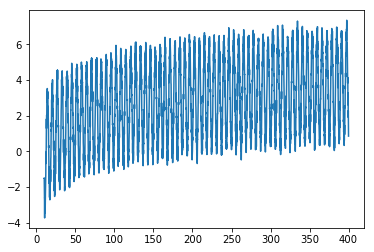

3900


In [4]:
data, data_len = Construct_TS(noise_level=0.3)
print(data_len)

In [5]:
def GetDataset(input_num=150, output_num=10, lag= 20,
               noise_level=0.3, sin_level=3, log_smo=0.1):
    
    
    #Get the timeseries :
    TS, TS_len = Construct_TS(noise_level, sin_level, log_smo)
    
    # Get the dataset (input, output) :
    Input_data  = []
    Output_data = []
    
    for i in range(TS_len-180):
        x = np.array(TS[i:i+input_num]) # Get the input
        y = np.array(TS[i+input_num+lag:i+input_num+lag+output_num]) # Get the output
        Input_data.append(x) # fill the dataset
        Output_data.append(y)
    
    Input_data = np.array(Input_data)
    Output_data = np.array(Output_data)
    
    return Input_data, Output_data
        

Time series shape is :  3900


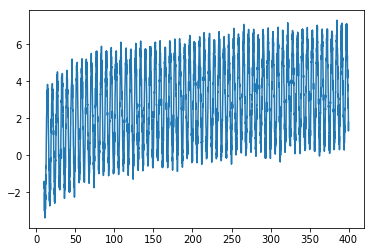

shape of input data :  (3720, 150)
shape of output data :  (3720, 10)


In [6]:
Input_data, Output_data = GetDataset()
print('shape of input data : ', np.shape(Input_data))
print('shape of output data : ', np.shape(Output_data))

In [7]:
## Transform the dataset to Tensorflow dataset :
len_data = len(Input_data)

Train_x = Input_data[:int(0.6*len_data)]
Train_y = Output_data[:int(0.6*len_data)]
print(len(Train_x))

Test_x = Input_data[int(0.6*len_data):int(0.8*len_data)]
Test_y= Output_data[int(0.6*len_data):int(0.8*len_data)]

Validation_x = Input_data[int(0.8*len_data):]
Validation_y=Output_data[int(0.8*len_data):]

2232


In [8]:
def Get_Batch(x, y, batch_size=128):
    # get he number of points in the dataset :
    size = len(x)
    #get a permutation :
    perm = npr.permutation(range(size))
    perm = perm[:batch_size]
    # get the inputs with the permutation index
    batch_x = [x[i] for i in perm]
    batch_y = [y[i] for i in perm]
    
    return batch_x, batch_y

#safety check :
x, y = Get_Batch(Train_x, Train_y)
print(np.shape(y))

(128, 10)


## 2._ Prediction task :

We will use many LSTm models, varying the she architecture, the number of layers, and the dimension of the hidden layers.

The best model will be saved and we will construct a Python class to use it for prediction.

In [9]:
###### Learning variables :
starter_learning_rate= 0.001
training_steps = 30000
batch_size = 128
display_step = 200
save_step = 5000

In [13]:
'''
    First Training : 
    
     LSTM varibales : 1 layers, 
                    layer_dim=[1], (same as the dimension of the output y)
                    
                    
'''
tf.reset_default_graph()
X = tf.placeholder("float", [None, 150, 1])
Y = tf.placeholder("float", [ 10, None, 1])

predictions = Multilayer_LSTM(X, 1, [1], 10, 150, False, [])
error_op = tf.metrics.mean_squared_error(Y, predictions)
loss_op = tf.losses.mean_squared_error(Y, predictions)
# optmisation op :
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           5000, 0.96, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
#initalize global variables :
init_global = tf.initialize_all_variables()
# initialize local varibales for metrics :
init_local = tf.local_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init_global)
    sess.run(init_local)   
    ### ****** Optimization process :
    for step in range(1, training_steps+1):
        batch_x, batch_y = Get_Batch(Train_x, Train_y, batch_size)
        # Reshape operations for ltm inputs/outputs :
        batch_x = np.reshape(batch_x, [batch_size, 150, 1])
        batch_y = np.reshape(np.transpose(batch_y), [10, batch_size, 1])
        # Train operation :
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        # display the results time to time :
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and mse_error
            mse_error, loss= sess.run([error_op, loss_op], feed_dict={X: batch_x, Y: batch_y})
            print("The Minibatch Loss for step : ", step, " is ", loss,
                 "The Training mse-error is ", mse_error)
            
        if step % save_step == 0 :
            saver.save(sess, 'checkpoint_directory/LSTM_TS', global_step=step)
    
    print("Optimization Finished!")
    ### ****** Get mse error for the test :
    test_len = 500
    test_data, test_label = Get_Batch(Test_x, Test_y, test_len)
    test_data = np.reshape(test_data, [test_len, 150, 1])
    test_label = np.reshape(np.transpose(test_label), [10, test_len, 1])
    print("Testing error : ", \
        sess.run(mse_error, feed_dict={X: test_data, Y: test_label}))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
The Minibatch Loss for step :  1  is  10.553194 The Training mse-error is  (0.0, 10.553194)
The Minibatch Loss for step :  200  is  8.237515 The Training mse-error is  (10.553194, 9.395355)
The Minibatch Loss for step :  400  is  6.7423134 The Training mse-error is  (9.395355, 8.511007)
The Minibatch Loss for step :  600  is  9.508652 The Training mse-error is  (8.511007, 8.760419)
The Minibatch Loss for step :  800  is  8.432788 The Training mse-error is  (8.760419, 8.694893)
The Minibatch Loss for step :  1000  is  7.689805 The Training mse-error is  (8.694893, 8.527378)
The Minibatch Loss for step :  1200  is  7.222242 The Training mse-error is  (8.527378, 8.34093)
The Minibatch Loss for step :  1400  is  6.604637 The Training mse-error is  (8.34093, 8.123894)
The Minibatch Loss for step :  1600  is  6.506051 The Training mse-error is  (8.123894, 7.9441333)
The Minibatch Loss for step :  1800  is  7.485414 The

KeyboardInterrupt: 